# 0.0 Importações

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime

## 0.1. Carregando os dados

In [2]:
df1 = pd.read_csv("datasets/May_2020.csv",low_memory=False)
df2 = pd.read_csv("datasets/Jun_2020.csv",low_memory=False)
df3 = pd.read_csv("datasets/Jul_2020.csv",low_memory=False)
df4 = pd.read_csv("datasets/Aug_2020.csv",low_memory=False)
df5 = pd.read_csv("datasets/Sep_2020.csv",low_memory=False)
df6 = pd.read_csv("datasets/Oct_2020.csv",low_memory=False)
df7 = pd.read_csv("datasets/Nov_2020.csv",low_memory=False)
df8 = pd.read_csv("datasets/Dec_2020.csv",low_memory=False)




In [3]:
list_df = [df1,df2,df3,df4,df5,df6,df7,df8]

In [4]:
data3 = pd.concat(list_df, axis = 0, ignore_index = True)


# 1.0. Descrição dos dados

## 1.1. Dimensão dos dados

In [5]:
print('numero de linhas: {}'.format(data3.shape[0]))
print('numero de colunas: {}'.format(data3.shape[1]))

numero de linhas: 3325334
numero de colunas: 13


## 1.2. Tipos dos dados

In [6]:
data3.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id      float64
end_station_name       object
end_station_id        float64
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [7]:
data3= data3.rename(columns={'member_casual':'user_type'})


## 1.3. Checando NA

In [8]:
data3.isnull().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    82957
start_station_id      83583
end_station_name      97545
end_station_id        98006
start_lat                 0
start_lng                 0
end_lat                4045
end_lng                4045
user_type                 0
dtype: int64

In [9]:
for i in data3:
    if i in ['start_station_name', 'end_station_name']:
        data3[i] = data3[i].fillna('Unknown')
    elif i in ['start_station_id', 'end_station_id']:
        data3[i] = data3[i].fillna(0)
    elif i in ['end_lat', 'end_lng']:
        data3.dropna(subset=['end_lat', 'end_lng'], inplace=True)

## 1.4. Checando tipos dos dados

In [10]:
data3.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id      float64
end_station_name       object
end_station_id        float64
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
user_type              object
dtype: object

In [11]:
data3['start_station_id']= data3['start_station_id'].astype('int64')
data3['end_station_id']= data3['end_station_id'].astype('int64')
data3['start_lat']= data3['start_lat'].astype(float)
data3['start_lng']= data3['start_lng'].astype(float)
data3['end_lat']= data3['end_lat'].astype(float)
data3['end_lng']= data3['end_lng'].astype(float)
data3['started_at']= pd.to_datetime(data3['started_at'])
data3['ended_at']= pd.to_datetime(data3['ended_at'])

# 2.0 Feature Engineering

## 2.1 Lista de hipoteses

**1.** Usuarios que utilizam as bikes eletricas gastam menos tempo em viagem.

**2.** Bikes elétricas são mais usadas.

**3.** No verão a frequencia de usuarios aumentam 30%.

**4.** No inverno a frequencia de usuarios caem 30%.

**5.** No verão as estações de bikes aumentam 40%.

**6.** Nos finais de semana a porcentagem de usuários aumentam em 50%.

**7.** Nos finais de semana a porcentagem de usuários aumentam em 50%.

**8.** A cada mês há um aumento de 10% de usuários ativos.

**9.** Os horarios de pico de usuario é as 6:00am e 18:00.

**10.** Os usuarios casuais gastam mais tempo em viagem, em média, do que os membros anuais.







## 2.4 Feature Engineering

In [12]:
#ano
data3['year']=data3['started_at'].dt.year

#mês
data3['month']=data3['started_at'].dt.month

#dia
data3['day']=data3['started_at'].dt.day

##tipo da semana : final de semana ou semana comum  Segunda=0, Domingo=6.
data3['type_week_numeric']=data3['started_at'].dt.weekday
data3['type_week_categoric']= data3['type_week_numeric'].apply(lambda x: "weekday" if x < 5 else "weekend")

#duração da viagem em minutos

data3['trip_duration'] = data3['ended_at'] - data3['started_at'] 
data3['trip_duration']= round(data3['trip_duration'].astype('timedelta64[s]') /60)

# hora do inicio da viagem
data3['started_at']= data3['started_at'].dt.strftime("%H")
data3['ended_at']= data3['ended_at'].dt.strftime("%H")
list_ = [data3['started_at'],data3['ended_at']]
data3['trip_start_hour'] = pd.concat(list_, axis = 0, ignore_index = True)



#estacoes do ano categorica
data3['season']= data3['month'].apply(lambda x: "spring" if (x >=3) & (x<=5) else
                                                      "summer" if (x>=6) & (x<=8) else
                                                       "fall" if (x>=9) & (x<= 11) else
                                                       "winter")
#estacoes do ano Numerica
#data3['season_numeric']= data3['month'].apply(lambda x: 1 if (x == 'spring') else
                                                       # 2 if (x == 'summer') else
                                                       # 3 if (x == "fall") else
                                                       # 4)

In [13]:
# Criando função que calcula a distancia entre dois pontos

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    
    return km

# Add new column with the distance between points
distance_km = haversine_np(data3['start_lng'], data3['start_lat'], data3['end_lng'], data3['end_lat'])

data3.insert(10, 'ride_distance_km', distance_km)

# 3.0. Filtragem de Váriaveis

## 3.1. Filtragem de Colunas

In [68]:
data_filters = data3.copy()

In [69]:
#apagar colunas
#cols_drop = ['started_at','ended_at']
#data_cols_drop= data_cols_drop.drop(cols_drop,axis=1)

In [70]:
data_filters=data_filters[['ride_id','rideable_type','start_station_name','end_station_name','user_type','day','month','type_week_categoric','season','trip_start_hour','ride_distance_km','trip_duration','start_lat','start_lng','end_lat','end_lng']].reset_index()

In [71]:
data_filters.dtypes

index                    int64
ride_id                 object
rideable_type           object
start_station_name      object
end_station_name        object
user_type               object
day                      int64
month                    int64
type_week_categoric     object
season                  object
trip_start_hour         object
ride_distance_km       float64
trip_duration          float64
start_lat              float64
start_lng              float64
end_lat                float64
end_lng                float64
dtype: object

## 3.2. Filtragem de Linhas

In [72]:
filter_ = data_filters['trip_duration'] > 0 
data_filters = data_filters[filter_]
data_filters

,index,ride_id,rideable_type,start_station_name,end_station_name,user_type,day,month,type_week_categoric,season,trip_start_hour,ride_distance_km,trip_duration,start_lat,start_lng,end_lat,end_lng
0,0,EACB19130B0CDA4A,docked_bike,Western Ave & Leland Ave,Clark St & Leland Ave,member,21,1,weekday,winter,20,1.736408,8.0,41.966500,-87.688400,41.967100,-87.667400
1,1,8FED874C809DC021,docked_bike,Clark St & Montrose Ave,Southport Ave & Irving Park Rd,member,30,1,weekday,winter,14,0.832887,4.0,41.961600,-87.666000,41.954200,-87.664400
2,2,789F3C21E472CA96,docked_bike,Broadway & Belmont Ave,Wilton Ave & Belmont Ave,member,9,1,weekday,winter,19,0.620047,3.0,41.940100,-87.645500,41.940200,-87.653000
3,3,C9A388DAC6ABF313,docked_bike,Clark St & Randolph St,Fairbanks Ct & Grand Ave,member,6,1,weekday,winter,16,1.230463,9.0,41.884600,-87.631900,41.891800,-87.620600
4,4,943BC3CBECCFD662,docked_bike,Clinton St & Lake St,Wells St & Hubbard St,member,30,1,weekday,winter,08,0.783132,6.0,41.885600,-87.641800,41.889900,-87.634300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321284,3325329,A9FA0D0987E7622B,docked_bike,Wentworth Ave & Cermak Rd,Michigan Ave & 18th St,member,20,11,weekday,fall,08,0.805845,4.0,41.853084,-87.631931,41.857813,-87.624550
3321285,3325330,4C5FE357D0F8F9B2,docked_bike,Michigan Ave & 18th St,Indiana Ave & 26th St,member,2,11,weekday,fall,18,1.358343,7.0,41.857813,-87.624550,41.845687,-87.622481
3321286,3325331,46867105425F25E3,docked_bike,Lake Shore Dr & Monroe St,Theater on the Lake,member,7,11,weekend,fall,17,5.169169,31.0,41.880958,-87.616743,41.926277,-87.630834
3321287,3325332,2830FAF63F52A386,docked_bike,Michigan Ave & 18th St,Michigan Ave & 18th St,member,8,11,weekend,fall,20,0.000000,24.0,41.857813,-87.624550,41.857813,-87.624550


# 4.0. Análise Exploratória

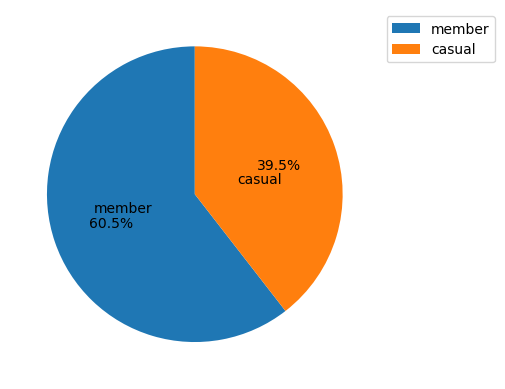

In [19]:
porc_members=(round(data_filters['user_type'].value_counts(normalize=True)*100,2))
plt.pie(porc_members,labels=porc_members.index[0:2],startangle=90,autopct='%1.1f%%',labeldistance=0.3,pctdistance=0.6,radius=1)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [20]:
# Top 10 lugares com mais retiradas de bikes
top10 =data_filters[['start_station_name','user_type']].groupby('user_type').value_counts().reset_index(name='withdrawal quantity')
top10[['start_station_name','user_type','withdrawal quantity']].sort_values('withdrawal quantity',ascending=False).head(10)

,start_station_name,user_type,withdrawal quantity
691,Unknown,member,46733
0,Unknown,casual,33154
1,Streeter Dr & Grand Ave,casual,25621
2,Lake Shore Dr & Monroe St,casual,19502
692,Clark St & Elm St,member,18539
3,Millennium Park,casual,18144
693,Kingsbury St & Kinzie St,member,15307
694,Broadway & Barry Ave,member,14442
4,Theater on the Lake,casual,14411
695,St. Clair St & Erie St,member,14299


In [21]:
# Distancia média entre usuarios
member_avg_distance = data_filters[['user_type', 'ride_distance_km']].groupby('user_type').mean()
member_avg_distance.reset_index(drop=False, inplace=True)
member_avg_distance.rename(columns={'user_casual':'Type', 'ride_distance_km':'AVG. Distance'}, inplace=True)
member_avg_distance

,user_type,AVG. Distance
0,casual,2.214094
1,member,2.252307


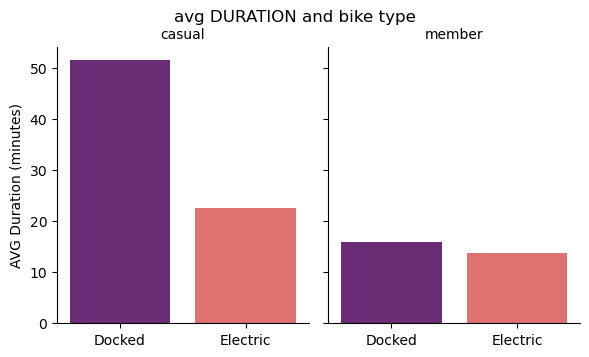

In [22]:
# Creating a data frame
avg_duration = data_filters[['user_type', 'rideable_type', 'trip_duration']].groupby(['user_type', 'rideable_type']).mean()
avg_duration.reset_index(drop=False, inplace=True)

# Barplot (facegrid)
g = sns.FacetGrid(avg_duration, col='user_type')
g.map(sns.barplot, 'rideable_type', 'trip_duration', order=[ 'docked_bike', 'electric_bike'], palette='magma')

# Non-data parameters
g.fig.suptitle('avg DURATION and bike type')
g.fig.set_size_inches(6,4)
g.set_titles(col_template="{col_name}")
g.set_axis_labels('', 'AVG Duration (minutes)')
g.set_xticklabels([ 'Docked', 'Electric'])

plt.show()

In [23]:
data_filters[['user_type','trip_duration']].groupby('user_type').mean().reset_index()

,user_type,trip_duration
0,casual,47.329953
1,member,15.728715


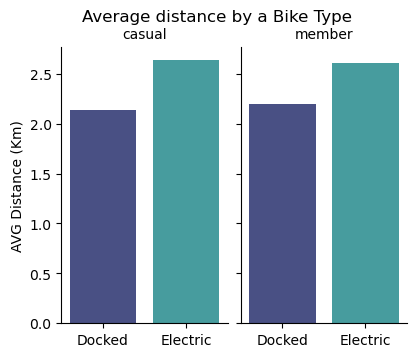

In [24]:
# Casual/Member avg DISTANCE and bike type
avg_distance = data_filters[['user_type', 'rideable_type', 'ride_distance_km']].groupby(['user_type', 'rideable_type']).mean()
avg_distance.reset_index(drop=False, inplace=True)

# Barplot (facegrid)
g = sns.FacetGrid(avg_distance, col='user_type')
g.map(sns.barplot, 'rideable_type', 'ride_distance_km', order=[ 'docked_bike', 'electric_bike'], palette='mako')

# Non-data parameters
g.fig.suptitle('Average distance by a Bike Type')
g.fig.set_size_inches(4,4)
g.set_titles(col_template="{col_name}")
g.set_axis_labels('', 'AVG Distance (Km)')
g.set_xticklabels([ 'Docked', 'Electric'])

plt.show()

In [25]:
 data_filters[['user_type', 'rideable_type', 'ride_distance_km']].groupby(['user_type', 'rideable_type']).mean().reset_index()

,user_type,rideable_type,ride_distance_km
0,casual,docked_bike,2.141426
1,casual,electric_bike,2.635606
2,member,docked_bike,2.199770
3,member,electric_bike,2.603408


## Insights

### H**1.** No verão a frequencia de usuarios aumentam 30% em relação ao inverno

C:\Users\wesle\anaconda3\envs\cyclistic\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


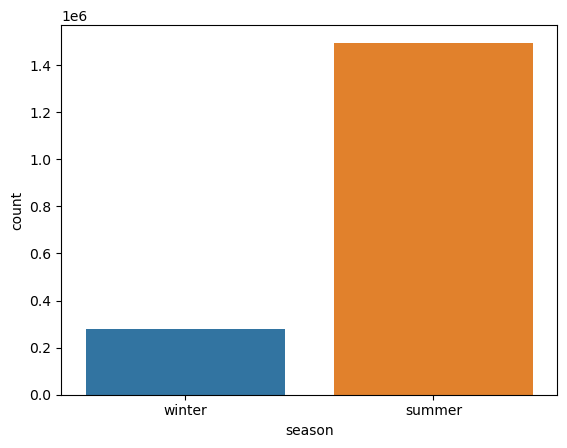

In [26]:
aux = data_filters.loc[(data_filters['season']== 'summer') | (data_filters['season']== 'winter')]
sns.countplot(aux['season']);

In [27]:
aux1=aux['season'].value_counts().reset_index()
round((aux1['season'][0] - aux1['season'][1]) / aux1['season'][0] * 100,2)


81.21

Verdadeiro. A porcentagem no verão é de 80% maior em relação ao inverno. 

### H2. Em agosto o numero de usuarios caiu 20% em relação a julho.

C:\Users\wesle\anaconda3\envs\cyclistic\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


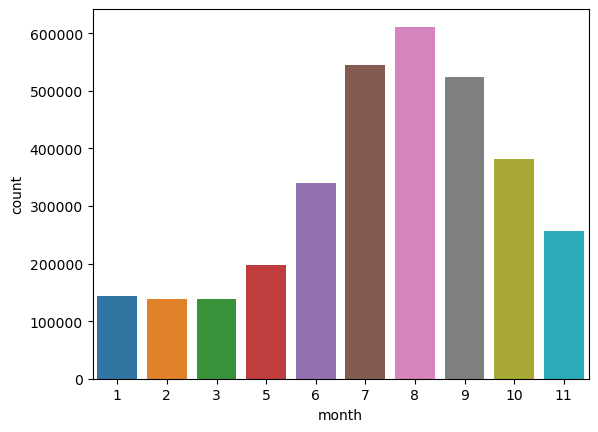

In [28]:
sns.countplot(data_filters['month']);

In [29]:
aux=data_filters['month'].value_counts().reset_index()
round((aux['month'][0] - aux['month'][1]) / aux['month'][0] * 100,2)


10.91

Falso. O numero de usuarios aumentou em quase 11%

### H**3.** No feriado de São Patricio o volume de usuarios aumentaram.


C:\Users\wesle\anaconda3\envs\cyclistic\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


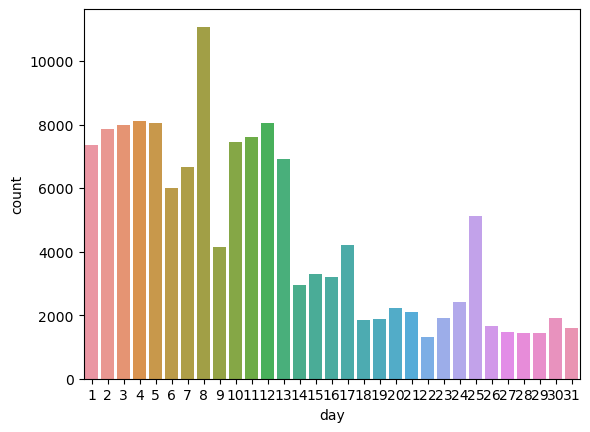

In [30]:
aux= data_filters[data_filters['month'] == 3]
sns.countplot(aux['day']);

In [31]:
aux1=aux['day'].value_counts().reset_index()
round((aux1['day'][0] - aux1['day'][13]) / aux1['day'][0] * 100,2)


62.1

Falso. O Numero de usuários caiu mais de 60% comparando com o melhor dia sem feriado.
O dia de São Patricio é comemorado dia 17 de março.

### H**4.** No inverno os depositos de bikes no centro são mais frequentes por usuarios anuais.

In [32]:
aux = data_filters[data_filters['season']== 'winter']
aux1=aux[['end_station_name','user_type']].value_counts().reset_index(name='sum_type_user')
aux1

,end_station_name,user_type,sum_type_user
0,Canal St & Adams St,member,6229
1,Clinton St & Washington Blvd,member,5296
2,Clinton St & Madison St,member,5125
3,Kingsbury St & Kinzie St,member,3405
4,Michigan Ave & Washington St,member,2838
...,...,...,...
1148,Laramie Ave & Madison St,member,1
1149,Kostner Ave & Lake St,member,1
1150,Knox Ave & Montrose Ave,casual,1
1151,Kilbourn Ave & Irving Park Rd,casual,1


Verdade. Maior parte dos dados está desconhecido. Mas a maioria prefere depositar as bike na Canal St & Adams St, localização de vários restaurantes e do principal metrô (chicago Union Station).

### H**5.** Nos finais de semana a porcentagem de usuários casuais aumentaram em 20%.


In [33]:
aux=data_filters[['type_week_categoric','user_type']].value_counts().reset_index(name='sum')

aux

,type_week_categoric,user_type,sum
0,weekday,member,1450874
1,weekday,casual,749160
2,weekend,casual,544153
3,weekend,member,530711


In [34]:
round((aux['sum'][1] - aux['sum'][2]) / aux['sum'][1] * 100,2)


27.36

Verdade. A porcentangem de usuários aumentou 27% nos finais de semana.

###  H**6.** A cada mês há um aumento de 10% de usuários casuais.


In [35]:
# contagem de usuarios por mês
aux=data_filters[['month','user_type']].value_counts(['month','user_type']).reset_index(name='user_total')
#ordenando
aux=aux.sort_values('month')

# porcentagem de usuario em relação a cada mês anterior (jan - fev / jan)
for i in range(0,len(aux)-1):
    aux.loc[i+1,'difference'] = round((aux.loc[i,'user_total'] - aux.loc[i+1,'user_total']) /aux.loc[i,'user_total'] *100,2)
    
aux1=aux[aux['user_type']=='casual']
aux1

,month,user_type,user_total,difference
19,1,casual,7752,36.94
18,2,casual,12294,49.97
17,3,casual,24574,71.54
16,5,casual,86333,0.74
9,6,casual,153573,9.10
4,7,casual,267087,3.76
2,8,casual,284940,3.90
6,9,casual,227417,4.76
10,10,casual,142365,7.30
15,11,casual,86978,22.30


Falso. A porcentagem de clientes por mês é muito váriavel. Em destaque o mês de março que teve um pico de usuários casuais. O motivo atípico é pela carreta do dia internacional da mulher.

### H**7.** Qual a diferenca de horarios entre usuarios, considerando dia, tarde e noite.


<AxesSubplot:xlabel='trip_start_hour', ylabel='total_per_hour'>

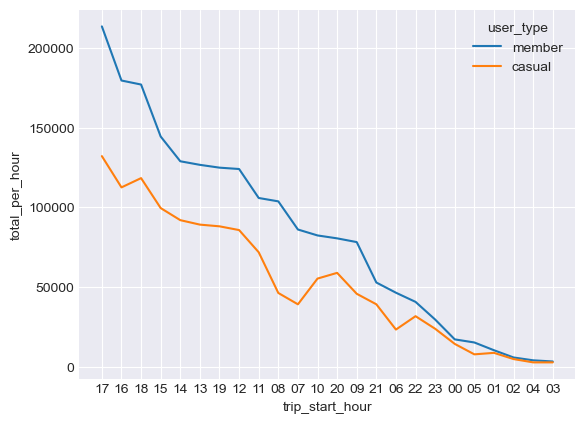

In [36]:
aux=data_filters[['trip_start_hour','user_type']].value_counts(['trip_start_hour','user_type'],ascending=False).reset_index(name='total_per_hour')

aux.head(10)
plt.style.use('seaborn-darkgrid')
sns.lineplot(data=aux, x="trip_start_hour", y="total_per_hour", hue="user_type")

In [37]:
aux[aux['user_type']== 'member'].sort_values('total_per_hour',ascending=True).head(15)

,trip_start_hour,user_type,total_per_hour
45,03,member,3218
44,04,member,3950
42,02,member,5740
39,01,member,10285
37,05,member,15157
36,00,member,17104
33,23,member,29567
29,22,member,40651
26,06,member,46409
25,21,member,52826


In [38]:
aux[aux['user_type']== 'casual'].sort_values('total_per_hour',ascending=False).head(14)

,trip_start_hour,user_type,total_per_hour
4,17,casual,132205
9,18,casual,118377
10,16,casual,112566
13,15,casual,99571
14,14,casual,91980
15,13,casual,89176
16,19,casual,88104
18,12,casual,85754
22,11,casual,71820
23,20,casual,58880


o horário de pico dos membros anuais é as 8h, 17h e 19h.
o horário de pico dos casuais é as 10h , 17hr e 19h.

In [39]:
madrugada_casual=aux[aux['user_type']== 'casual'].sort_values('total_per_hour',ascending=True).head(5)
madrugada1=madrugada_casual['total_per_hour'].sum()

madrugada_member=aux[aux['user_type']== 'member'].sort_values('total_per_hour',ascending=True).head(5)
madrugada2=madrugada_member['total_per_hour'].sum()


round((madrugada2- madrugada1) / madrugada2 * 100,2)


31.19

# Perguntas de Negócio

In [104]:
datafilter = data_filters.copy()

## 1.	Como os membros anuais e os ciclistas casuais usam as bicicletas da Cyclistic de forma diferente?

 - Os membros Anuais preferem frequentar centros urbanos onde possuem bares e lojas.
 - Os Casuais preferem visitar Parques , Praças e Lagos.
 - Em média os usuários casuais passam mais tempo pedalando, cerca de 66% a mais.
 - Em média a distância percorrida entre os usuários casuais é 23% maior que os membros anuais.
 - Houve um aumento de 20% dos usuários casuais usanso as bikes no fim de semana.
 - Os membros Anuais usam a bike mais cedo as 8:00am enquanto casuais começam usar as 10:00am, enquanto no período da tarde e noite há um fluxo maior de usabilidade entre os dois usuários durante as 17h e 19h.
 - Durante esses 10 meses mais de 2500 usuários usaram as bicicletas durante a madrugada, entre 00:00 e 5:00 hrs. Os membros Anuais são 30% maior que casuais.
 - Usuários casuais usam mais bikes no final de semana, cerca de 2% ou 13.500 a mais que anuais.
 - Comparando os Casuais entre a semana e fim de semana, cerca de 27% ou 200 mil usam durante a semana.
 - Verão e Outono são as estações mais frequentadas por Casuais e Membros Anuais.
 - No inverno os usuários casuais representam 0,61% do total de 100% dividido por estações, parece pouco, mas são 20.000 pessoas.
 

Dashboard com Análises e Mapa interativo para você explorar:

https://public.tableau.com/views/DashboardCyclistic_16673119130170/Painel1?:language=pt-BR&:display_count=n&:origin=viz_share_link

In [105]:
# Salvando dados limpos
data_filters.to_csv('data_clean.csv')

# Criando relatório de recomendações de potenciais clientes

#apagar colunas desnecessárias para o relatóro
cols_drop = ['start_lat','start_lng','end_lat','end_lng','index']
casuais= datafilter.drop(cols_drop,axis=1)



In [106]:
#filtrando apenas clientes casuais
casuais = casuais[casuais['user_type'] == 'casual'].reset_index()
casuais

,index,ride_id,rideable_type,start_station_name,end_station_name,user_type,day,month,type_week_categoric,season,trip_start_hour,ride_distance_km,trip_duration
0,20,3479141FF24AD595,docked_bike,Lake Shore Dr & Monroe St,Michigan Ave & Washington St,casual,16,1,weekday,winter,17,0.741092,30.0
1,33,CDA4546AFB6F34F5,docked_bike,Logan Blvd & Elston Ave,Stockton Dr & Wrightwood Ave,casual,5,1,weekend,winter,13,3.766905,30.0
2,152,69A8CB6748CA2DB0,docked_bike,Burling St (Halsted) & Diversey Pkwy (Temp),Broadway & Sheridan Rd,casual,22,1,weekday,winter,15,2.196704,125.0
3,157,1DD6245D8E796F48,docked_bike,Milwaukee Ave & Grand Ave,Damen Ave & Grand Ave,casual,29,1,weekday,winter,22,2.358020,10.0
4,189,7C3CF816107BE767,docked_bike,Broadway & Barry Ave,Clark St & Wrightwood Ave,casual,20,1,weekday,winter,10,0.914968,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293308,3321268,A1004267BA9F6015,docked_bike,Lakefront Trail & Bryn Mawr Ave,Clark St & North Ave,casual,20,11,weekday,fall,16,8.182926,77.0
1293309,3321270,4B656B6E9922A7F8,docked_bike,Pine Grove Ave & Irving Park Rd,Stetson Ave & South Water St,casual,13,11,weekday,fall,14,7.801792,34.0
1293310,3321272,B49DB2A84D925151,docked_bike,Green St & Randolph St,Dearborn St & Erie St,casual,9,11,weekday,fall,07,1.969551,9.0
1293311,3321278,C15DCDB789E7C72B,docked_bike,Paulina St & Flournoy St,Peoria St & Jackson Blvd,casual,23,11,weekday,fall,08,1.696602,10.0


In [107]:
# contando o total de usuarios por estação
aux = casuais[['user_type','start_station_name']].value_counts('start_station_name',ascending=False).reset_index(name='start_user_total')

# criando coluna 'ride_id' em aux para fazer o merge
aux['ride_id']= casuais['ride_id']

# contando o total de usuarios por estação
aux2 = casuais[['user_type','end_station_name']].value_counts('end_station_name',ascending=False).reset_index(name='end_user_total')

# criando coluna 'ride_id' em aux para fazer o merge
aux2['ride_id']= casuais['ride_id']


# fazendo o merge com identificador unico, onde a coluna 'start_user_total' é atribuida
aux = pd.merge(aux, aux2, how='inner', on='ride_id')


# fazendo o merge com identificador unico, onde a coluna 'end_user_total' é atribuida
casuais = pd.merge(casuais, aux, how='inner', on='ride_id')

# filtrando dados com estações acima de 500 retiradas
filtro = casuais['start_user_total']>=500
casuais = casuais[filtro]
casuais

# filtrando dados com estações acima de 500 retiradas
filtro = casuais['end_user_total']>=500
casuais = casuais[filtro]
casuais

,index,ride_id,rideable_type,start_station_name_x,end_station_name_x,user_type,day,month,type_week_categoric,season,trip_start_hour,ride_distance_km,trip_duration,start_station_name_y,start_user_total,end_station_name_y,end_user_total
0,20,3479141FF24AD595,docked_bike,Lake Shore Dr & Monroe St,Michigan Ave & Washington St,casual,16,1,weekday,winter,17,0.741092,30.0,Unknown,33154,Unknown,41092
1,33,CDA4546AFB6F34F5,docked_bike,Logan Blvd & Elston Ave,Stockton Dr & Wrightwood Ave,casual,5,1,weekend,winter,13,3.766905,30.0,Streeter Dr & Grand Ave,25621,Streeter Dr & Grand Ave,28139
2,152,69A8CB6748CA2DB0,docked_bike,Burling St (Halsted) & Diversey Pkwy (Temp),Broadway & Sheridan Rd,casual,22,1,weekday,winter,15,2.196704,125.0,Lake Shore Dr & Monroe St,19502,Millennium Park,19010
3,157,1DD6245D8E796F48,docked_bike,Milwaukee Ave & Grand Ave,Damen Ave & Grand Ave,casual,29,1,weekday,winter,22,2.358020,10.0,Millennium Park,18144,Lake Shore Dr & Monroe St,18833
4,189,7C3CF816107BE767,docked_bike,Broadway & Barry Ave,Clark St & Wrightwood Ave,casual,20,1,weekday,winter,10,0.914968,41.0,Theater on the Lake,14411,Theater on the Lake,16242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,8118,274BCF6A86B82399,docked_bike,Southport Ave & Wellington Ave,Sheffield Ave & Wellington Ave,casual,20,1,weekday,winter,08,0.903513,5.0,Racine Ave & Congress Pkwy,549,Budlong Woods Library,524
413,8144,9B307A4C01DE90C5,docked_bike,Spaulding Ave & Division St,Austin Blvd & Chicago Ave,casual,1,1,weekday,winter,03,5.486618,423.0,Racine Ave & 15th St,544,New St & Illinois St,523
414,8172,049561ECBA29B1B0,docked_bike,LaSalle Dr & Huron St,LaSalle St & Illinois St,casual,6,1,weekday,winter,23,0.458308,8.0,Glenwood Ave & Touhy Ave,537,Warren Park East,522
415,8177,F1B132241E27DBA0,docked_bike,Southport Ave & Roscoe St,Halsted St & Roscoe St,casual,9,1,weekday,winter,22,1.239826,8.0,St. Louis Ave & Balmoral Ave,533,St. Louis Ave & Balmoral Ave,506


- Principais insights dos lugares mais frequentados por casuais:
   - A principal estação do ano é o inverno.
   - O principal foco é ir patinar no gelo.
   - Todos vão no mês de Janeiro.
   - A segundas maiores atrações são Teatro, Restaurante e Museu.

In [108]:
# Exportando a tabela com as recomendações
casuais.to_csv('recommendations.csv', index=False)

## 2.	Por que os passageiros casuais iriam querer adquirir planos anuais da Cyclistic?


- RECOMENDAÇÔES:
    - Um plano Anual apenas para o finais de semana.
    - Um plano Anual Familia.
    - Programa de pontos acumulados em km, ganhando cupons de desconto para trocar com parceiros nos pontos mais frequentados.
    - Descontos para Usuários novos.
    - Descontos parceria em teatros, cinemas e Museus.
    - cashback por completar desafios anuais.

## 3.	Como a Cyclistic pode usar a mídia digital para influenciar os passageiros casuais a se tornarem membros?


- A Cyclistic pode utilizar os meios digitais para influenciar os ciclistas casuais a tornarem-se membros ao falar sobre os impactos positivos na saúde pessoal e na saúde do planeta que o programa de partilha de bicicletas proporciona. 

- Os clientes podem ser atraídos por ideias de ajudar a apoiar um estilo de vida saudável, melhorar a qualidade do ar, reduzir o tráfego e o congestionamento.

- Geração de Leads usando cookies visitas no app/site.

- Fazer parcerias com digitais influencers e lançar cupom de desconto para novos usuários.

- Propaganda em podcast de saude e bem estar.

- Publicidade em todas as redes sociais.

- Publicidade atrás dos onibus da prefeitura.

- Divulgações de eventos e dicas pelo app.

